### Data Visualisation and Topic Modelling

#### Reddit Domestic Abuse Dataset: https://nicschrading.com/data/

In [1]:
import pandas as pd
import shelve

<img src="data/redditAbuseSubmissions.PNG" alt="Drawing" style="width: 400px;"/>

In [3]:
#redditAbuseSubmissions

redditAbuseSubmissions = shelve.open("data/redditAbuseSubmissions")

In [4]:
text = redditAbuseSubmissions["data"]

label = redditAbuseSubmissions["labels"]

subIds = redditAbuseSubmissions["subIds"]

In [5]:
#Creating a dataframe with data

data = {'id':subIds, 'text':text, 'label':label}

data = pd.DataFrame(data)

data.head()

,id,text,label
0,2wjl43,I cant eat pls help I need help\nMy anxiety ha...,non_abuse
1,2tdh8q,"Financial Independence I am 18, with no job an...",abuse
2,2vwei8,Who decided that online calculus assignments w...,non_abuse
3,p013r,My friend recently told me she was abused as a...,abuse
4,2xrdhg,How's it going on this monday night? I am list...,non_abuse


# 1. Data Analysis

In [6]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop = list(stop)
from string import punctuation
from functools import reduce

from collections import Counter
import re
import numpy as np

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

%matplotlib inline

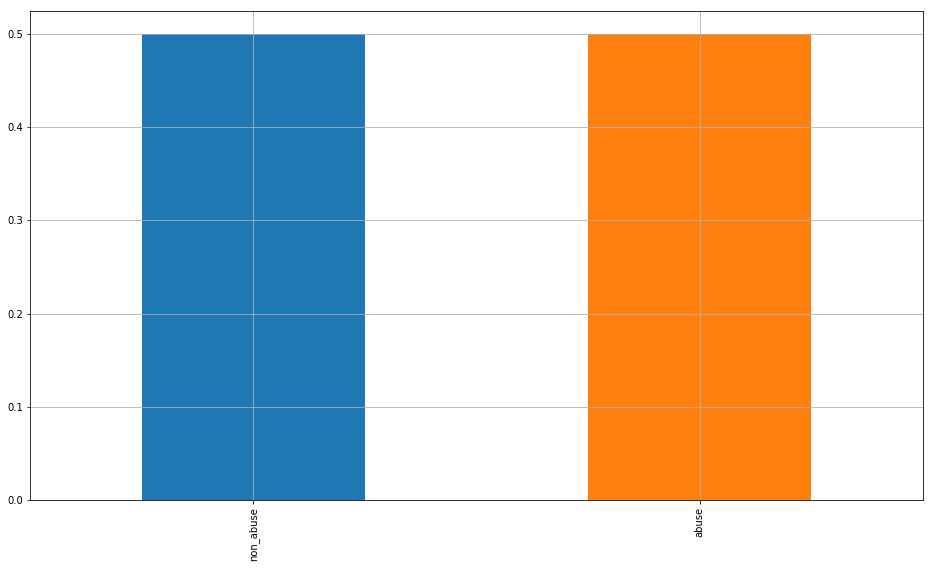

In [7]:
data.label.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [8]:
data.shape

(1104, 3)

In [9]:
#Calculating the average length of text subreddit

print("Average length of text: ",sum(data.text.map(len))//1104)

Average length of text:  1088


In [10]:
#Function to remove Non-Ascii characters
#Source: https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

In [11]:
#Function to clean text
#Source: https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [12]:
#Function to tokenize the data and add a column

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop + list(punctuation)) , tokens))
    tokens = [s.split(" ") for s in tokens]
    return tokens

In [21]:
run = False
if run:
    # run this (takes times)
    data['tokens'] = data['text'].progress_map(lambda d: tokenizer(d))
    data.to_csv('new_data_with_tokens.csv', index=False)
else:
    # or import the dataset directly
    data = pd.read_csv('data/new_data_with_tokens.csv')
    from ast import literal_eval
    data.loc[:,'tokens'] = data.loc[:,'tokens'].apply(lambda x: literal_eval(x))

In [22]:
data.head()

,id,text,label,tokens
0,2wjl43,I cant eat pls help I need help\nMy anxiety ha...,non_abuse,"[cant, eat, pls, help, need, help, anxiety, gr..."
1,2tdh8q,"Financial Independence I am 18, with no job an...",abuse,"[financial, independence, job, friends, new, c..."
2,2vwei8,Who decided that online calculus assignments w...,non_abuse,"[decided, online, calculus, assignments, good,..."
3,p013r,My friend recently told me she was abused as a...,abuse,"[friend, recently, told, abused, child, since,..."
4,2xrdhg,How's it going on this monday night? I am list...,non_abuse,"[going, monday, night, listening, new, purity,..."


### Most Common Words

In [23]:
def keywords(label):
    tokens = data[data['label'] == label]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(50)

In [24]:
for label in set(data['label']):
    print('label :', label)
    print('top 10 keywords:', keywords(label))
    print('---')

label : abuse
top 10 keywords: [('would', 595), ('know', 564), ('like', 553), ('abuse', 439), ('time', 400), ('feel', 400), ('help', 382), ('get', 378), ('want', 375), ('really', 349), ('one', 320), ('years', 307), ('even', 274), ('back', 260), ('abusive', 258), ('never', 249), ('things', 241), ('relationship', 241), ('told', 236), ('could', 232), ('think', 226), ('life', 224), ('go', 223), ('still', 222), ('going', 218), ('family', 217), ('people', 216), ('need', 214), ('got', 201), ('mother', 183), ('much', 183), ('something', 177), ('make', 173), ('abused', 170), ('first', 170), ('year', 170), ('way', 169), ('happened', 166), ('started', 163), ('also', 161), ('anything', 158), ('friends', 153), ('since', 152), ('someone', 147), ('said', 145), ('day', 145), ('friend', 144), ('see', 141), ('mom', 140), ('right', 140)]
---
label : non_abuse
top 10 keywords: [('like', 528), ('get', 446), ('know', 371), ('would', 359), ('feel', 357), ('want', 310), ('really', 300), ('time', 294), ('anxie

### Text Processing : tf-idf

To remove some of the stop words still present such as "day"

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
vectorizer = TfidfVectorizer(min_df=12,analyzer='word', stop_words='english', norm='l2')

vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

(1104, 1135)

In [26]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

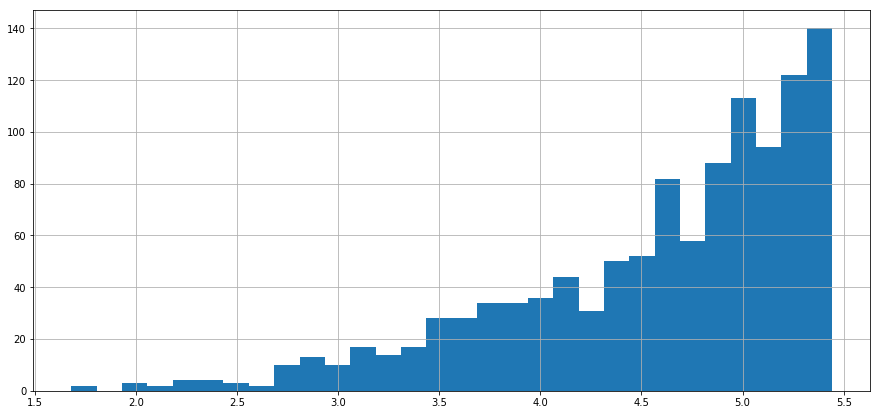

In [27]:
tfidf.tfidf.hist(bins=30, figsize=(15,7))

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [31]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
ability,5.442651
psychologist,5.442651
circumstances,5.442651
luck,5.442651
manager,5.442651
march,5.442651
cheated,5.442651
miserable,5.442651
mutual,5.442651
occasion,5.442651


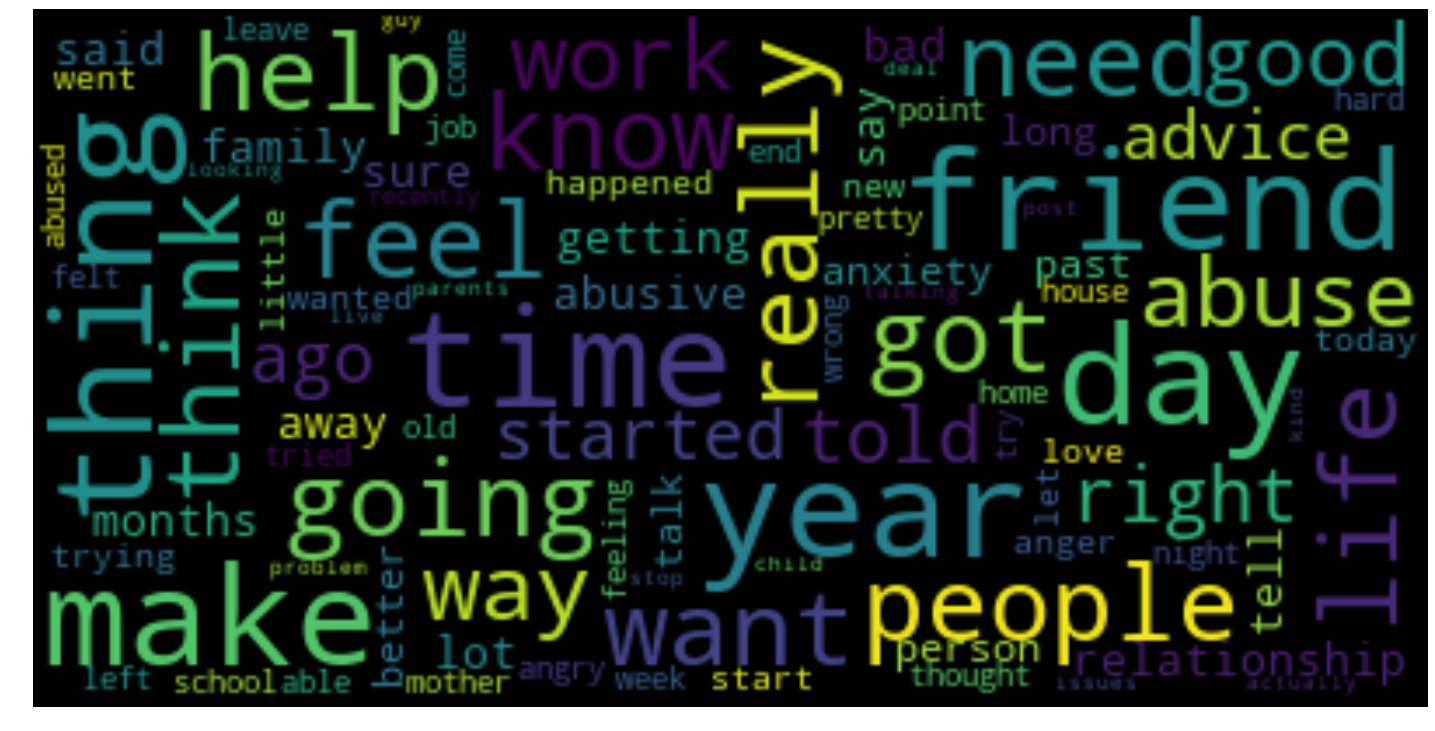

In [32]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(100))

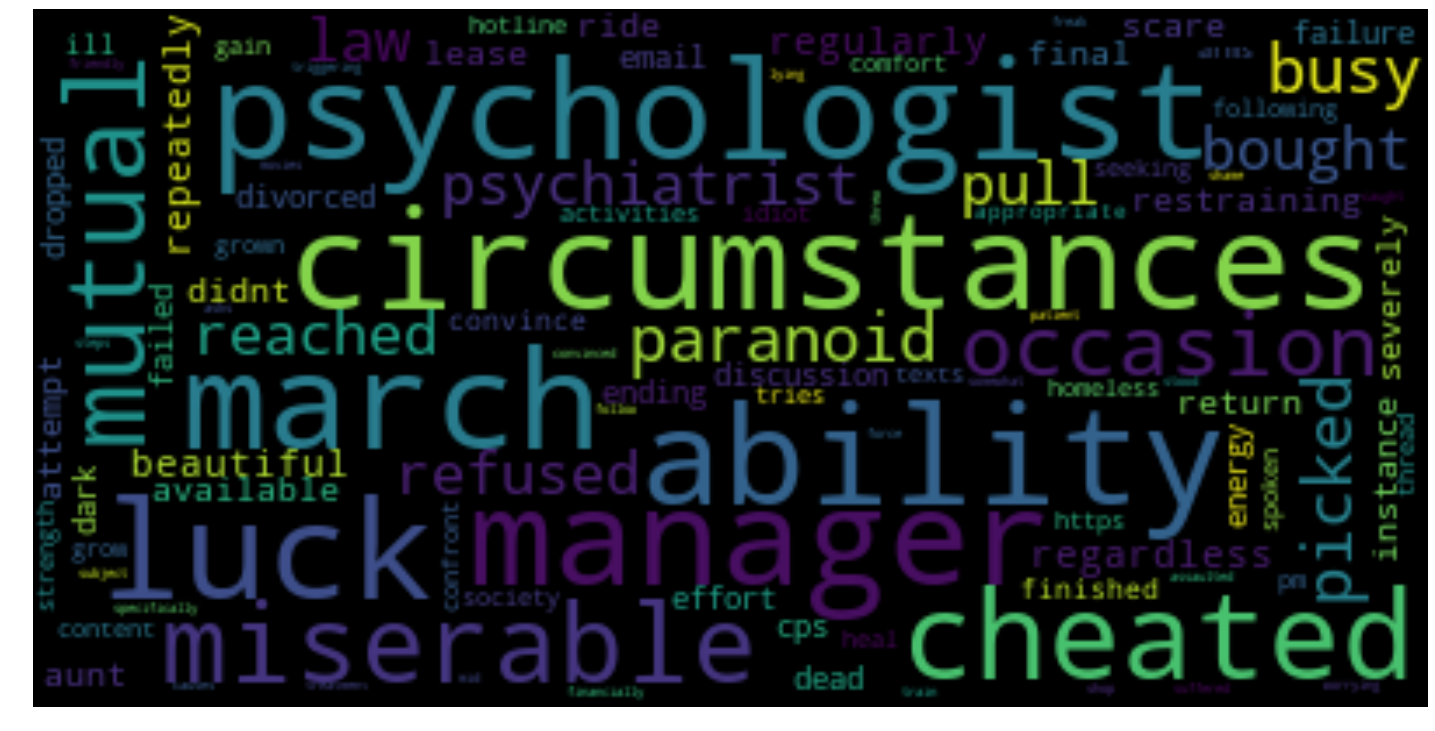

In [33]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(100))

Source (NMF): http://jpfairbanks.net/2017/07/15/email-topics-with-nmf/

In [34]:
from sklearn.decomposition import NMF

In [35]:
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(vz)

In [36]:
feature_names = vectorizer.get_feature_names()
no_top_words = 10

for topic_idx, topic in enumerate(nmf.components_[:2]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
know | really | time | want | going | things | think | friends | people | got
Topic 1:
anxiety | panic | attacks | attack | anxious | doctor | depression | social | medication | start


In [37]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]

In [38]:
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = ("topic_%d:" % topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [39]:
topic_table(nmf, feature_names, no_top_words).head(10)

,topic_0:,topic_1:,topic_2:,topic_3:,topic_4:,topic_5:,topic_6:,topic_7:,topic_8:,topic_9:
0,know,anxiety,anger,abuse,domestic,job,com,help,sister,like
1,really,panic,angry,therapy,violence,work,http,need,mother,feel
2,time,attacks,control,sexual,shelter,company,www,advice,mom,feeling
3,want,attack,problem,emotional,women,working,html,want,dad,life
4,going,anxious,rage,years,support,money,imgur,im,family,people
5,things,doctor,calm,abused,survivor,new,link,needs,brother,feels
6,think,depression,management,child,amp,jobs,comments,wife,father,normal
7,friends,social,issues,abuser,www,career,org,friend,kids,tired
8,people,medication,fucking,survivor,help,day,https,know,abused,make
9,got,start,mad,survivors,victim,experience,reddit,live,years,really


In [40]:
data_samples = list(data['tokens'].map(lambda tokens: ' '.join(tokens)))

data_labels = list(data['label'].map(lambda tokens: ' '.join(tokens)))

docweights = nmf.transform(vectorizer.transform(data_samples))

In [41]:
# plt.figure(figsize=(40,10))
# plt.imshow(docweights[0:200, :].T, aspect=8, interpolation='none')
# plt.title('Topic Weighting from NMF')
# plt.xlabel('document')
# plt.ylabel('Topic')
# plt.colorbar()

In [42]:
new_feedback = ["abuse","mother","grandma"]

A = vectorizer.transform(new_feedback)

W = nmf.components_

H = nmf.transform(A)

print('A is {} x {}'.format(*A.shape))
print('W is {} x {}'.format(*W.shape))
print('H is {} x {}'.format(*H.shape))

A is 3 x 1135
W is 10 x 1135
H is 3 x 10


In [43]:
df = pd.DataFrame({'label':data_labels,
                   'topic':docweights.argmax(axis=1),
                   'body':data_samples},
                  columns=['label', 'topic', 'body'])

In [44]:
df_abuse = df[df['label']=='a b u s e']

In [45]:
df_abuse['topic'].value_counts().index.values[:15]

array([0, 3, 8, 6, 4, 9, 7, 5, 2, 1])

In [46]:
df_non_abuse = df[df['label']=='n o n _ a b u s e']

In [47]:
df_non_abuse['topic'].value_counts().index.values[:15]

array([0, 1, 2, 9, 5, 7, 6, 8, 4, 3])

In [48]:
"""
    showdocs(df, topics, nshow=5) is a function that gathers a number of 
    documents from a set of topics as a dataframe.
"""
def showdocs(df, topics, nshow=5):
    idx = df.topic == topics[0]
    for i in range(1, len(topics)):
        idx = idx | (df.topic == topics[i])
    return df[idx].groupby('topic').head(nshow).sort_values('topic')

In [49]:
abuse = [0, 3, 8, 7, 4, 6, 9, 2, 5, 1]
non_abuse = [0, 1, 2, 5, 9, 8, 7, 6]

In [50]:
showdocs(df_abuse, [4,6])['body']

40     killing suicide get would like understand bett...
82     thinking becoming social worker work domestic ...
303    would like know would helpful know domestic vi...
343    resources children witness domestic violence g...
359    beginning internship anti domestic violence or...
90     emdr looking support x post r raisedbynarcissi...
96     took years newest blog entry entry daughters n...
195    idea individuals willing sacrifice children gi...
348    surviving rape culture feels like something cl...
366    crazy enough trade scar open wound jody allard...
Name: body, dtype: object

In [51]:
data.columns

Index(['id', 'text', 'label', 'tokens'], dtype='object')

In [224]:
data.iloc[1].values[1]

'Financial Independence I am 18, with no job and no friends in a new city (Sacramento) living with my abusive boyfriend. I am currently completely financially dependent on my boyfriend. I am looking for a job but the search is taking longer then I had hoped and I want to have the option to leave. I was wondering if anyone knew about any services to help domestic violence victims find work. '